In [42]:
import numpy as np
import os
import threading
import operator
import pickle
import re
import pandas as pd
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

start_time = 1190146243
end_time = 1192994591

def dump_data(data, output_name):
    with open(output_name, 'wb') as f:
        pickle.dump(data, f)

def load_data(input_name):
    with open(input_name, 'rb') as f:
        data = pickle.load(f)
    return data


import pickle
from tqdm import tqdm_notebook as tqdm
import pandas
import numpy
import matplotlib
matplotlib.rcParams.update({'font.size': 18})


from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import os
from tqdm import tqdm_notebook as tqdm
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas
import re
import os

# Data Formatting

## Access-update data

In [3]:
revisions_df = load_data("data/dump/revision_records.pkl")
access_series = load_data("data/dump/hot_words_100000.pkl")

In [8]:
from ipywidgets import IntProgress
word_with_revision = set(revisions_df.index.get_level_values(0))
access_update = {}
p = IntProgress(max=100000)
p.description = 'Running'
display(p)
for word in access_series.index:
    if word not in word_with_revision:
        access_update[word] = {"access": access_series[word], "update": 0}
    else:
        access_update[word] = {
            "access": access_series[word],
            "update": len(revisions_df.loc[word])
        }
    p.value += 1

access_update = pd.DataFrame(access_update).transpose()
access_update = access_update.drop(['Main_Page', 'Wiki', 'wiki'])

IntProgress(value=0, description='Running', max=100000)

In [13]:
access_update = load_data("data/dump/access_update_dataframe.pkl")
#dump_data(access_update, "data/dump/access_update_dataframe.pkl")

## Access-vandalism data

In [ ]:
import numpy as np
import pandas as pd

revision_df = load_data("data/dump/revision_records.pkl")

def check_vandalism(word, revision_df):
    revision = revision_df.loc[word]
    revision = revision.sort_values(by=['revid'])
    revision = revision.set_index('revid')
    index = revision.index
    df = pd.DataFrame(columns = ['timestamp', 'vandal','restorer','recovery time'])
    for i in range(1, len(index) - 1):
        last_record = revision.loc[index[i-1]]
        current_record = revision.loc[index[i]]
        next_record = revision.loc[index[i+1]]
        
        before_size = last_record['size']
        current_size = current_record['size']
        after_size = next_record['size']
        
        if current_size < 0.5 * after_size and after_size == before_size:
            df.loc[index[i]] = {'timestamp': current_record['timestamp'],
                                'vandal': current_record['user'], 
                                'restorer': next_record['user'],
                                'recovery time': next_record['timestamp'] - current_record['timestamp']}
   
    return df

In [ ]:
from ipywidgets import IntProgress

revision_df = load_data("data/dump/revision_records.pkl")
word_list = set(revision_df.index.get_level_values(0))
nworkers = 4
threads = [None] * nworkers
flags = [True] * nworkers


def target(index, flags, results, title):
    try:
        df = check_vandalism(title, revision_df)
    except:
        df = None
    if df is not None:
        results[title] = df
    flags[index] = True


p = IntProgress(max=len(word_list))
display(p)
results = {}
for title in word_list:
    index = 0
    while True:
        try:
            index = flags.index(True)
            flags[index] = False
            break
        except:
            continue
    t = threading.Thread(target=target, args=[index, flags, results, title])
    threads[index] = t
    t.start()
    p.value += 1

for thread in threads:
    if thread:
        thread.join()

vandalism_records = pd.concat(results.values(), keys=results.keys())
#dump_data(vandalism_records, "data/dump/vandalism_records.pkl")

In [ ]:
from ipywidgets import IntProgress

access_series = load_data("data/dump/hot_words_100000.pkl")
vandalism_records = load_data("data/dump/vandalism_records.pkl")

word_vandalized = set(vandalism_records.index.get_level_values(0))
access_vandalism = {}
p = IntProgress(max=100000)
p.description = 'Running'
display(p)

for word in access_series.index:
    if word not in word_vandalized:
        access_vandalism[word] = {
            "access": access_series[word],
            "vandalism": 0
        }
    else:
        access_vandalism[word] = {
            "access": access_series[word],
            "vandalism": len(vandalism_records.loc[word])
        }
    p.value += 1

access_vandalism = pd.DataFrame(access_vandalism).transpose()
access_vandalism = access_vandalism.drop(['Main_Page', 'Wiki', 'wiki'])
#dump_data(access_vandalism, "data/dump/access_vandalism_dataframe.pkl")

## reconvery records

In [ ]:
from ipywidgets import IntProgress

access_series = load_data("data/dump/hot_words_100000.pkl")
vandalism_records = load_data("data/dump/vandalism_records.pkl")

recovery_records = {}
p = IntProgress(max=len(vandalism_records))
p.description = 'Running'
display(p)

for i in range(len(vandalism_records)):
    record = vandalism_records.iloc[i]
    word = record.name[0]
    freq = access_series[word]
    recovery_records[i] = {
        "restorer": record['restorer'],
        "recovery time": record['recovery time'],
        "word frequency": freq
    }
    p.value += 1

recovery_records = pd.DataFrame(recovery_records).transpose()
#dump_data(recovery_records, "data/dump/recovery_records.pkl")

# Hypothesis 1: Access frequency with Update frequency 

In [52]:
def seperate_list(array, bins=10):
    arrary1 = sorted(array)
    cut = []
    delta = len(arrary1) // bins
    print(delta)
    for j in range(0, bins):
        if len(cut) > 0 and arrary1[delta * j] == cut[-1]:
            continue
        cut.append(arrary1[delta * j])
    cut.append(arrary1[-1])
    return cut

3604


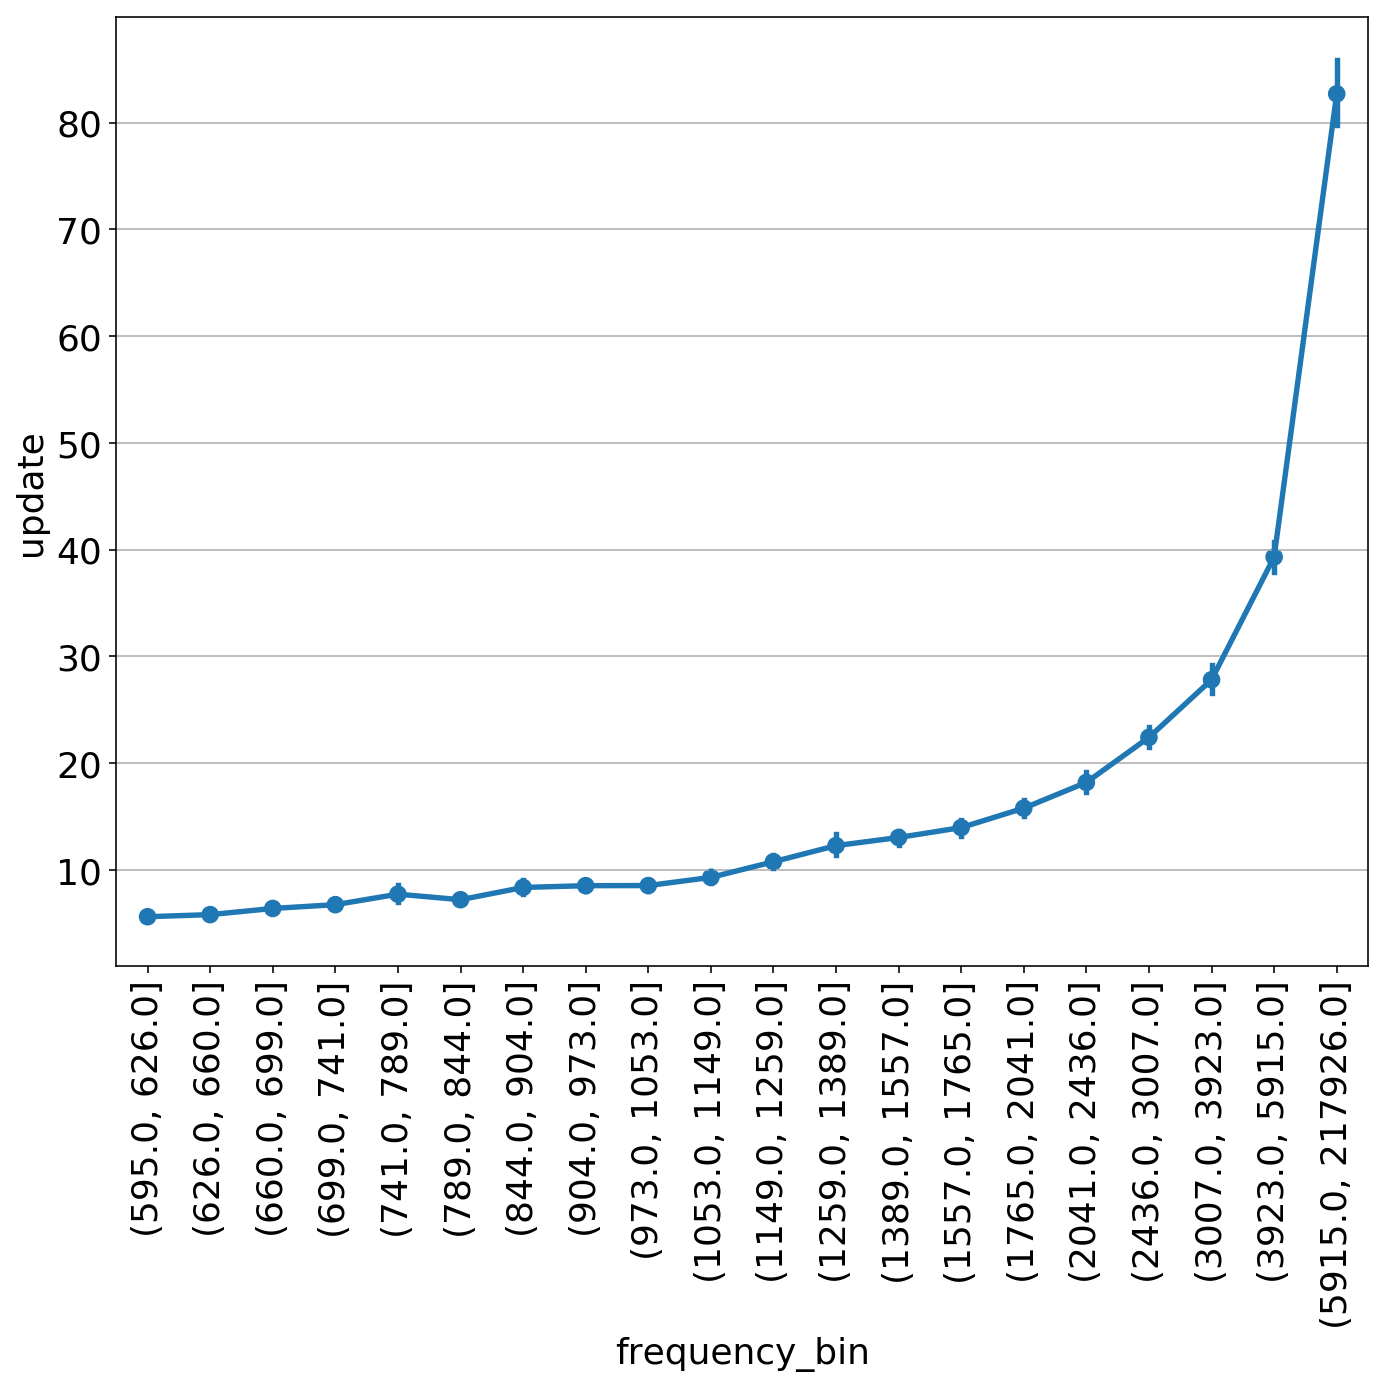

In [53]:
# load data
visit_count_df = pickle.load(open('./data/dump/merged_metadata.pkl', 'rb'))
visit_count_df.head()

# plot
column = 'update'
plt.figure(figsize=(10, 10))
visit_count_df['frequency_bin'] = pandas.cut(
    visit_count_df['frequency'],
    seperate_list(visit_count_df['frequency'].values, 20))
sns.pointplot(y=visit_count_df[column], x='frequency_bin', data=visit_count_df)
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
#plt.savefig('./plots/title_frequency_%s.png'%column,dpi=400)
plt.show()

In [67]:
from pydoc import help
from scipy.stats.stats import pearsonr
import numpy as np
import pickle
visit_count_df = pickle.load(open('./data/dump/merged_metadata.pkl', 'rb'))
pearsonr((visit_count_df['update'] + 1),(visit_count_df['frequency'] +1))

(0.5446776364123359, 0.0)

# Hypothesis 2: # vandalism with access frequency

All words are considered.

3604


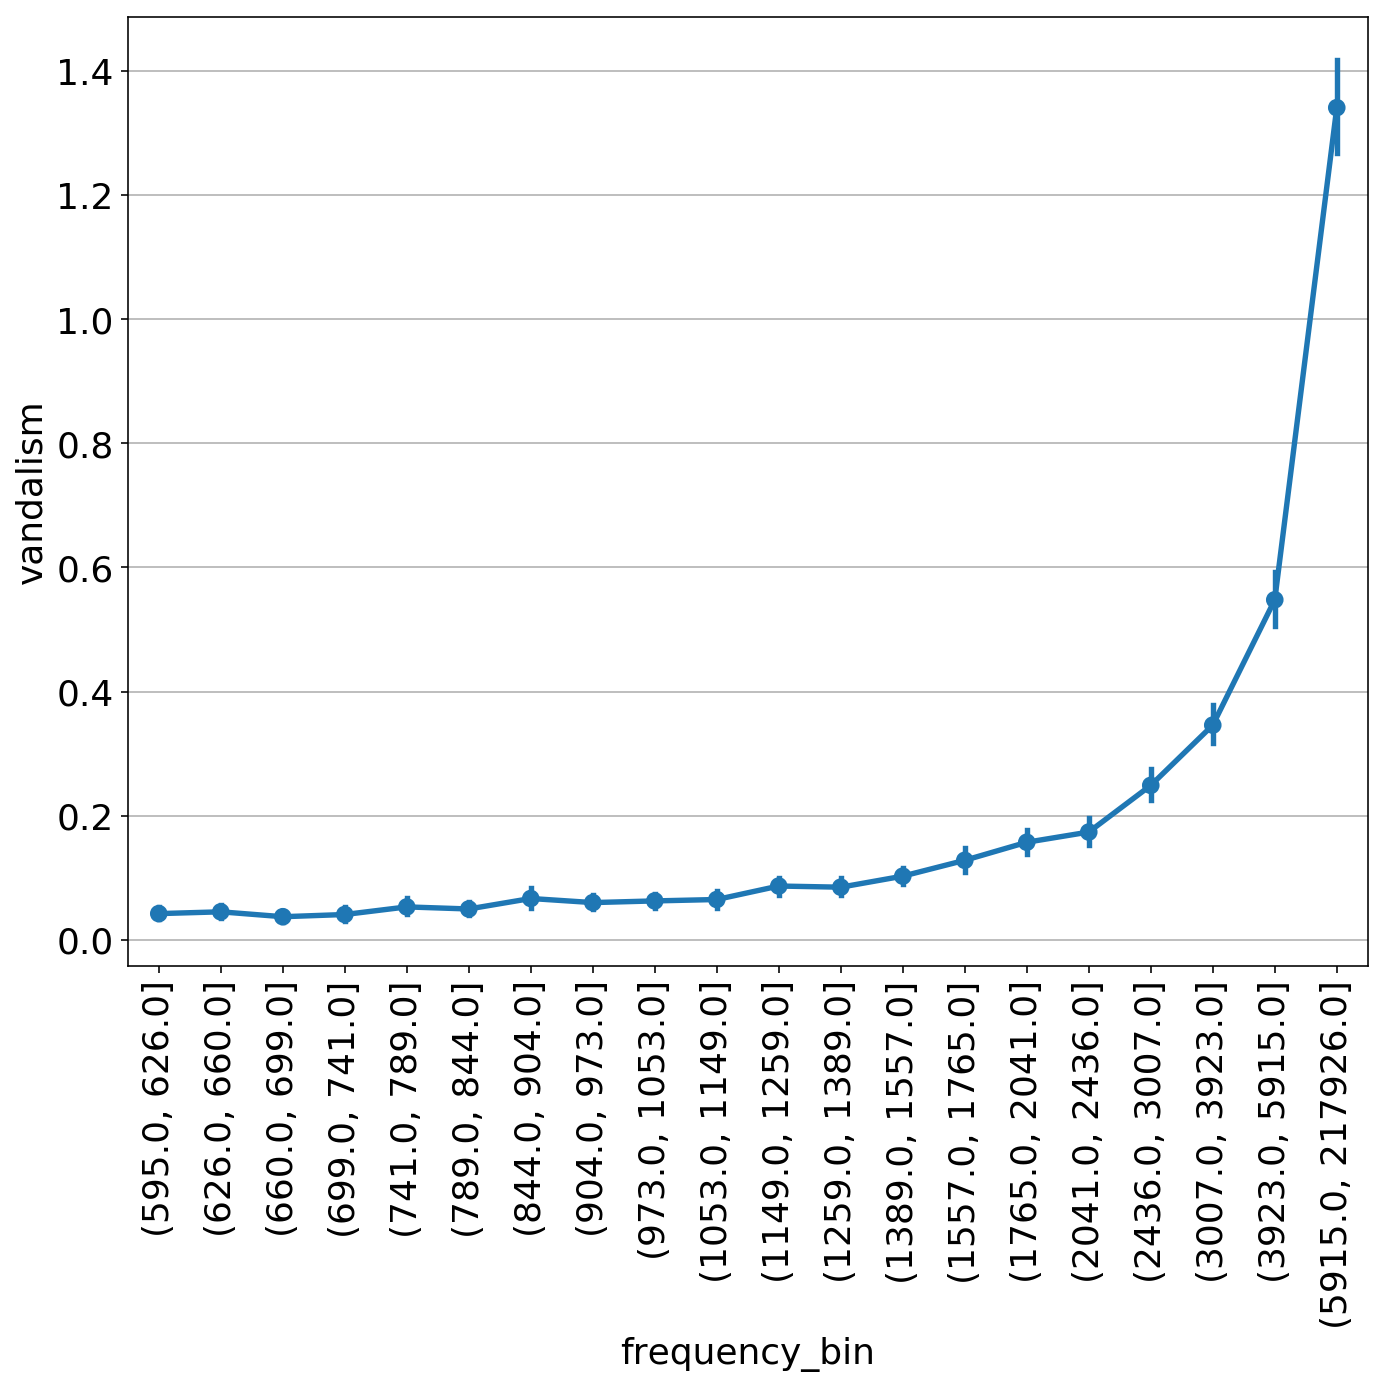

In [62]:
# load data
visit_count_df = pickle.load(open('./data/dump/merged_metadata.pkl', 'rb'))
visit_count_df.head()

# plot
column = 'vandalism'
plt.figure(figsize=(10, 10))
visit_count_df['frequency_bin'] = pandas.cut(
    visit_count_df['frequency'],
    seperate_list(visit_count_df['frequency'].values, 20))
sns.pointplot(y=visit_count_df[column], x='frequency_bin', data=visit_count_df)
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
#plt.savefig('./plots/title_frequency_%s.png'%column,dpi=400)
plt.show()

In [73]:
from pydoc import help
from scipy.stats.stats import pearsonr
import numpy as np
import pickle
visit_count_df = pickle.load(open('./data/dump/merged_metadata.pkl', 'rb'))
pearsonr((visit_count_df['vandalism'] + 1),(visit_count_df['update'] +1))

(0.5159172471475588, 0.0)

# Hypothesis 3 : Bot VS Human in finding vandalism

In [55]:
recovery_records = load_data("data/dump/recovery_records.pkl")

In [56]:
bot_data = []
human_data = []
for index, row in recovery_records.iterrows():
    if 'Bot' in row['restorer']:
        bot_data.append(row['recovery time'])
    else:
        human_data.append(row['recovery time'])

In [57]:
print(len(bot_data))
print(len(human_data))

10334
8156


In [58]:
bot_data_selected = np.random.choice(bot_data, len(human_data))

In [59]:
import scipy.stats as ss


def wald_test(X, Y, one_side=False):
    '''
    X: array-like
    Y: array-like
    X and Y should be in the same length
    return: p-value
    '''
    x = np.array(X)
    y = np.array(Y)
    n = X.shape[0]
    T = np.abs(np.mean(x) - np.mean(y)) / np.sqrt((x.var() + x.var()) / n)
    p = ss.norm.cdf(-T, 0, 1)
    if not one_side:
        p *= 2
    return np.mean(x), np.mean(y), p


def interval_of_mean(series, alpha):
    x = np.array(series)
    # https://books.google.com/books?id=ZBi1DAAAQBAJ&pg=PA111&lpg=PA111&dq=python+t_%7Bn-1%7D,%5Calpha/2&source=bl&ots=48wZ7PQS7K&sig=rH-nPDg3iKiaB7RKGGMvuAu31H8&hl=en&sa=X&ved=0ahUKEwj4iKrwpNTaAhUlheAKHcz5AS8Q6AEIQDAC#v=onepage&q=python%20t_%7Bn-1%7D%2C%5Calpha%2F2&f=false
    return ss.norm.interval(alpha, loc=np.mean(x), scale=ss.sem(x))

### Normal-based CI

In [60]:
bot_interval = interval_of_mean(bot_data, 0.95)
human_interval = interval_of_mean(human_data, 0.95)
print(bot_interval)
print(human_interval)

(11.260452856191424, 11.594975825829092)
(1732.5801074493756, 3084.0057189361078)


### Wald's Test

In [61]:
x, y, p = wald_test(bot_data_selected, human_data, one_side=False)
print("p-value:", p)

p-value: 0.0
